# Neural Networks

In this assignment, you will implement a 2-hidden layer neural network. The network should be able to accomodate any number of neurons per hidden layer (but the code need only accomodate 2 hidden layers).

Your implementation should only go under the # TODO sections. Do not modify any other part of the tutorial.


In [1]:
# Package imports
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

# Initialize random seed - for reproducibility. DO NOT CHANGE
np.random.seed(0)

## Generating a dataset

We will generate a non-linearly separable dataset using the Scikit datasets library (specifically, the make_moons dataset).

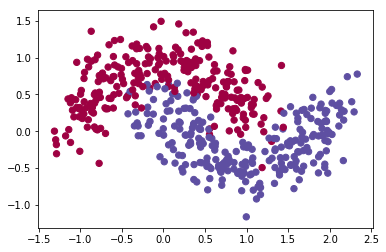

In [2]:
# Generate a dataset and plot it
X, y = sklearn.datasets.make_moons(500, noise=0.22, random_state=0)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)

The dataset we generated has two classes, plotted as red and blue points. The data is collected in $X$ and $y$ variables, where $X$ is a $Nx2$ dimensional matrix where each row represents a data point in the 2D space, i.e.
$$
X = \left[
\begin{array}{c}
    {x^{(1)}}^T \\
    {x^{(2)}}^T \\
    \vdots \\
     {x^{(N)}}^T
\end{array}
\right] 
=\left[
\begin{array}{cc}
    x_1^{(1)} & x_2^{(1)} \\
    x_1^{(2)} & x_2^{(2)} \\
    \vdots & \vdots \\
    x_1^{(N)} & x_2^{(N)} 
\end{array}
\right]
$$

such that the $n^{th}$ data point $x^{(n)}$ is a 2D vector of the form $$x^{(n)} = \left[ \begin{array}{c} x_1^{(n)}\\ x_2^{(n)}\end{array}\right]$$

The $y$ variable is a $Nx1$ vector such that the $i^{th}$ element represents the class (0 or 1) of the datapoint in the $i^{th}$ row of $X$.

Our goal is to train a Neural Network classifier that predicts the correct class (0 or 1) of each datapoint.

In [3]:
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

## Training a Neural Network

Given our neural network architecture, we now need to pick an *activation function* for our hidden layer. The activation function transforms the inputs of the layer into its outputs. For our purposes, we will choose the sigmoid function as our activation function.

The output of our network will also have a sigmoid function applied to it. We then classify a data point as class 1 if the output is greater or equal to 0.5, and 0 otherwise.

### Activation Function (and its derivative)

The activation function of choice is the sigmoid function discussed in class. Specifically, we have
$$
\sigma(a) = \frac{1}{1 + \exp(-a)}
$$
Furthermore, the derivative of this function with respect to $a$ is
$$
    \sigma'(a) = \sigma(a)\left(1-\sigma(a)\right)
$$

In [4]:
def sigmoid(a):
    """ Compute the sigmoid function
        Note: use the exponential function from the numpy library (i.e. np.exp()) 
              in your sigmoid function. This allows the function to compute the 
              sigmoid values (element-wise) for an array of numbers.
        
        Parameters: 
            a: the input value
        
        Output: 
            1 / (1 + e^(-a))
    """
    
    # TODO: Your implementation goes here
    return 1 / (1 + np.exp(-a))


In [5]:
def sigmoid_derivative(a):
    """ Compute the value of the derivative of a sigmoid function
        Note: you can use the above function here
        
        Parameters: 
            a: the input value
        
        Output: 
            derivative of the sigmoid function applied to 'a'
    """
    # TODO: Your implementation goes here
    return sigmoid(a)*(1 - sigmoid(a))

### How our network makes predictions

Our network makes predictions using *forward propagation*, which is just a bunch of matrix multiplications and the application of the activation function(s) we defined above. If $x$ is the 2-dimensional input to our network then we calculate our prediction $\hat{y}$ (also two-dimensional) as follows:

$$
\begin{aligned}
z_1 & = x^T W_1 + b_1 \\
a_1 & = \sigma(z_1) \\
z_2 & = a_1^T W_2 + b_2 \\
a_2 & = \sigma(z_2) \\
z_3 & = a_2^T W_3 + b_3\\
a_3 & = \hat{y} = \sigma(z_3)
\end{aligned}
$$

where $z_i$ is the weighted sum of inputs of layer $i$ (bias included) and $a_i$ is the output of layer $i$ after applying the activation function. $W_1, b_1, W_2, b_2, W_3, b_3$ are all the parameters of our network, which we need to learn from our training data. 

Note that the above is for a single data point $x$. If we work with the entire matrix of data points $X$ (which you should do), then the expressions change slightly due to this being matrix algebra. Specifically, we have the (now) vector $z_1$ being computed as
$$
z_1 = XW_1 + b_1
$$
(only the transpose operation was removed). You can figure out the remaining steps on your own. If you get lost, draw the matrices on a piece of paper and work it out step by step, making sure that the matrix dimensions match at each step.

### Learning the Parameters

Learning the parameters for our network means finding parameters ($W_1, b_1, W_2, b_2, W_3, b_3$) that minimize the error on our training data. We will define the training error simply as the average number of missclassifications. In other words

$$
\begin{aligned}
L(y,\hat{y}) = \frac{1}{N} \sum_{n \in N} | \hat{y}_n - y_{n} |
\end{aligned}
$$



where $\hat{y}_n \in \{0, 1\}$ is the predicted class and $y_n \in \{0, 1\}$ is the true value.

To learn the parameters, we update them iteratively through a process called backpropagation. In each iteration, we update the the parameters in a three-step process. First, perform a "forward pass" in order to calculate the errors per layer, which are defined as
$$
\begin{aligned}
& \delta_4 = (\hat{y} - y) \circ \sigma'(z_3)\\
& \delta_3 = \sigma'(z_2) \circ \delta_4W_3^T \\
& \delta_2 = \sigma'(z_1) \circ \delta_3W_2^T \\
\end{aligned}
$$

Second, we compute the derivatives of the error with respect to each of the parameters, i.e.

$$
\begin{aligned}
& \frac{\partial{L}}{\partial{W_3}} = a_2^T \delta_4  \\
& \frac{\partial{L}}{\partial{b_3}} = \delta_4\\
& \frac{\partial{L}}{\partial{W_2}} = a_1^T \delta_3  \\
& \frac{\partial{L}}{\partial{b_2}} = \delta_3\\
& \frac{\partial{L}}{\partial{W_1}} = x^T \delta_2\\
& \frac{\partial{L}}{\partial{b_1}} = \delta_2 \\
\end{aligned}
$$

Finally, the gradient descent update rules are then defined as 
$$
\begin{align}
    W_i &= W_i - \eta \frac{\partial L}{\partial W_i}\\
    b_i &= b_i - \eta \frac{\partial L}{\partial b_i}
\end{align}
$$

This process is repeated over a fixed number of iterations (called epochs). The final parameter settings are returned as the trained model.

### Implementation

First, implement the predict function which takes in input data and returns the predicted labels.

In [6]:
def predict(model, X):
    """ Takes a set of data points and predicts a label (0 or 1) for each. A data point has
        a predicted class of 1 if the final layer of the neural network outputs a value greater or equal
        to 0.5. Otherwise, the label is 0
        
        Parameters:
            model: a dictionary of parameters
            X: a NxK matrix, where each row represents a single data point.
            
        Output:
            A Nx1 Numpy vector, where the i'th value is the label (0 or 1) for the i'th datapoint in X
    """
    
    W1, b1, W2, b2, W3, b3 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3']
    
    Z1 = X.dot(W1) + b1
    A1 = sigmoid(Z1)
    Z2 = A1.dot(W2) + b2
    A2 = sigmoid(Z2)
    Z3 = A2.dot(W3) + b3
    A3 = sigmoid(Z3)
    
    classify = np.vectorize(lambda x: 1 if x > 0.5 else 0)
    
    return classify(A3)
    

Second, implement the loss function we defined above. We use this to evaluate how well our model is doing:

In [7]:
def calculate_loss(model, data):
    """ Compute the loss for the data provided, given the model.
        
        Parameters:
            model: a dictionary of parameters
            data:  a tuple containing the X and y data points, where X is 
                   an NxK matrix and y is a Nx1 vector of labels
            
        Output:
            A value for the loss function.
    """
    
    X, y = data[0], data[1]
    W1, b1, W2, b2, W3, b3 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3']

    y_hat = predict(model, X)

    return float(np.sum(np.absolute(y[:, np.newaxis] - y_hat))) / len(X)

We also implement a helper function to calculate the output of the network. It does forward propagation as defined above and returns the class with the highest probability.

Finally, here comes the function to train our Neural Network. It implements batch gradient descent using the backpropagation derivates we found above.

In [8]:
def train_nn(data, h1_dim, h2_dim, learning_rate=0.01, num_epochs=5000, verbose=False):
    """ Train the parameters of the neural network by performing backpropagation 
        on a training set.
    
        Parameters:
            data          : a tuple containing the X and y data points, where X is 
                            an NxK matrix and y is a Nx1 vector of labels
            h1_dim        : number of neurons in the first hidden layer
            h2_dim        : number of neurons in the second hidden layer
            learning_rate : the learning rate for gradient descent
            num_epochs    : number of total iterations of gradient descent. One 
                            iteration means updating the parameters once based on the
                            entire dataset.
            verbose       : if set to True, the loss function value is printed every 
                            100 iterations
        
        Output:
            A dictionary containing all parameters of the neural network. The keys 
            of the dictionary are: W1, b1, W2, b2, W3, b3
    """
    
    X, y = data[0], data[1]
    
    num_examples = len(X)        # training set size
    input_dim = 2                # number of neurons in the input layer
    output_dim = 1               # number of neurons in the output layer
      
    # Initialize the parameters to random values. We need to learn these.
    W1 = np.random.randn(input_dim, h1_dim) / np.sqrt(input_dim)
    b1 = np.zeros((1, h1_dim))
    W2 = np.random.randn(h1_dim, h2_dim) / np.sqrt(h2_dim)
    b2 = np.zeros((1, h2_dim))
    W3 = np.random.randn(h2_dim, output_dim) / np.sqrt(output_dim)
    b3 = np.zeros((1, output_dim))
    

    # UPDATE THIS AFTER EACH ITERATION
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3' : W3, 'b3' : b3}
    
    for i in range(0, num_epochs):
        Z1 = X.dot(W1) + b1
        A1 = sigmoid(Z1)
        Z2 = A1.dot(W2) + b2
        A2 = sigmoid(Z2)
        Z3 = A2.dot(W3) + b3
        A3 = sigmoid(Z3)
        classify = np.vectorize(lambda x: 1 if x > 0.5 else 0)
        y_hat = classify(A3)
        if i % 100 == 0 and verbose:
            print(float(np.sum(np.absolute(y_hat - y[:, np.newaxis]))) / len(X))
        # Update the 3rd layer
        d4 = (A3 - y[:, np.newaxis]) * sigmoid_derivative(Z3)
        dW3 = A2.T.dot(d4)
        W3 = W3 - learning_rate * dW3
        db3 = np.sum(d4, axis=0)
        b3 = b3 - learning_rate * db3
        # Update the 2nd layer
        d3 = d4.dot(W3.T) * sigmoid_derivative(Z2)
        dW2 = A1.T.dot(d3)
        W2 = W2 - learning_rate * dW2
        db2 = np.sum(d3, axis=0)
        b2 = b2 - learning_rate * db2
        # Update the 1st layer
        d2 = d3.dot(W2.T) * sigmoid_derivative(Z1)
        dW1 = X.T.dot(d2)
        W1 = W1 - learning_rate * dW1
        db1 = np.sum(d2, axis=0)
        b1 = b1 - learning_rate * db1
        model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3'] = W1, b1, W2, b2, W3, b3 
    return model

### Training a simple network with 2 neurons per hidden layer.

In [9]:
# Build a model 
data = [X,y]
model = train_nn(data, 2, 2, verbose=True)

0.5
0.226
0.13
0.134
0.132
0.132
0.134
0.134
0.134
0.134
0.134
0.134
0.134
0.134
0.134
0.134
0.134
0.134
0.134
0.134
0.134
0.134
0.134
0.134
0.134
0.134
0.134
0.134
0.134
0.134
0.134
0.134
0.134
0.134
0.134
0.134
0.134
0.134
0.134
0.134
0.134
0.134
0.134
0.134
0.134
0.134
0.134
0.134
0.134
0.134


Text(0.5, 1.0, 'Decision Boundary for hidden layers of sizes 2 and 2')

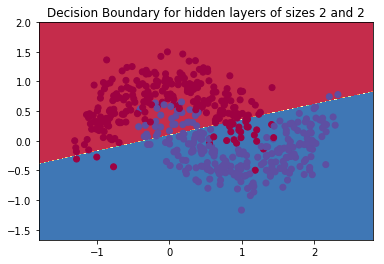

In [10]:
# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layers of sizes 2 and 2")

# Varying the hidden layer size

We now vary the number of neurons in the hidden layers and observe what happens to the decision boundary. This part can take a few minutes to run. Just let it be :)


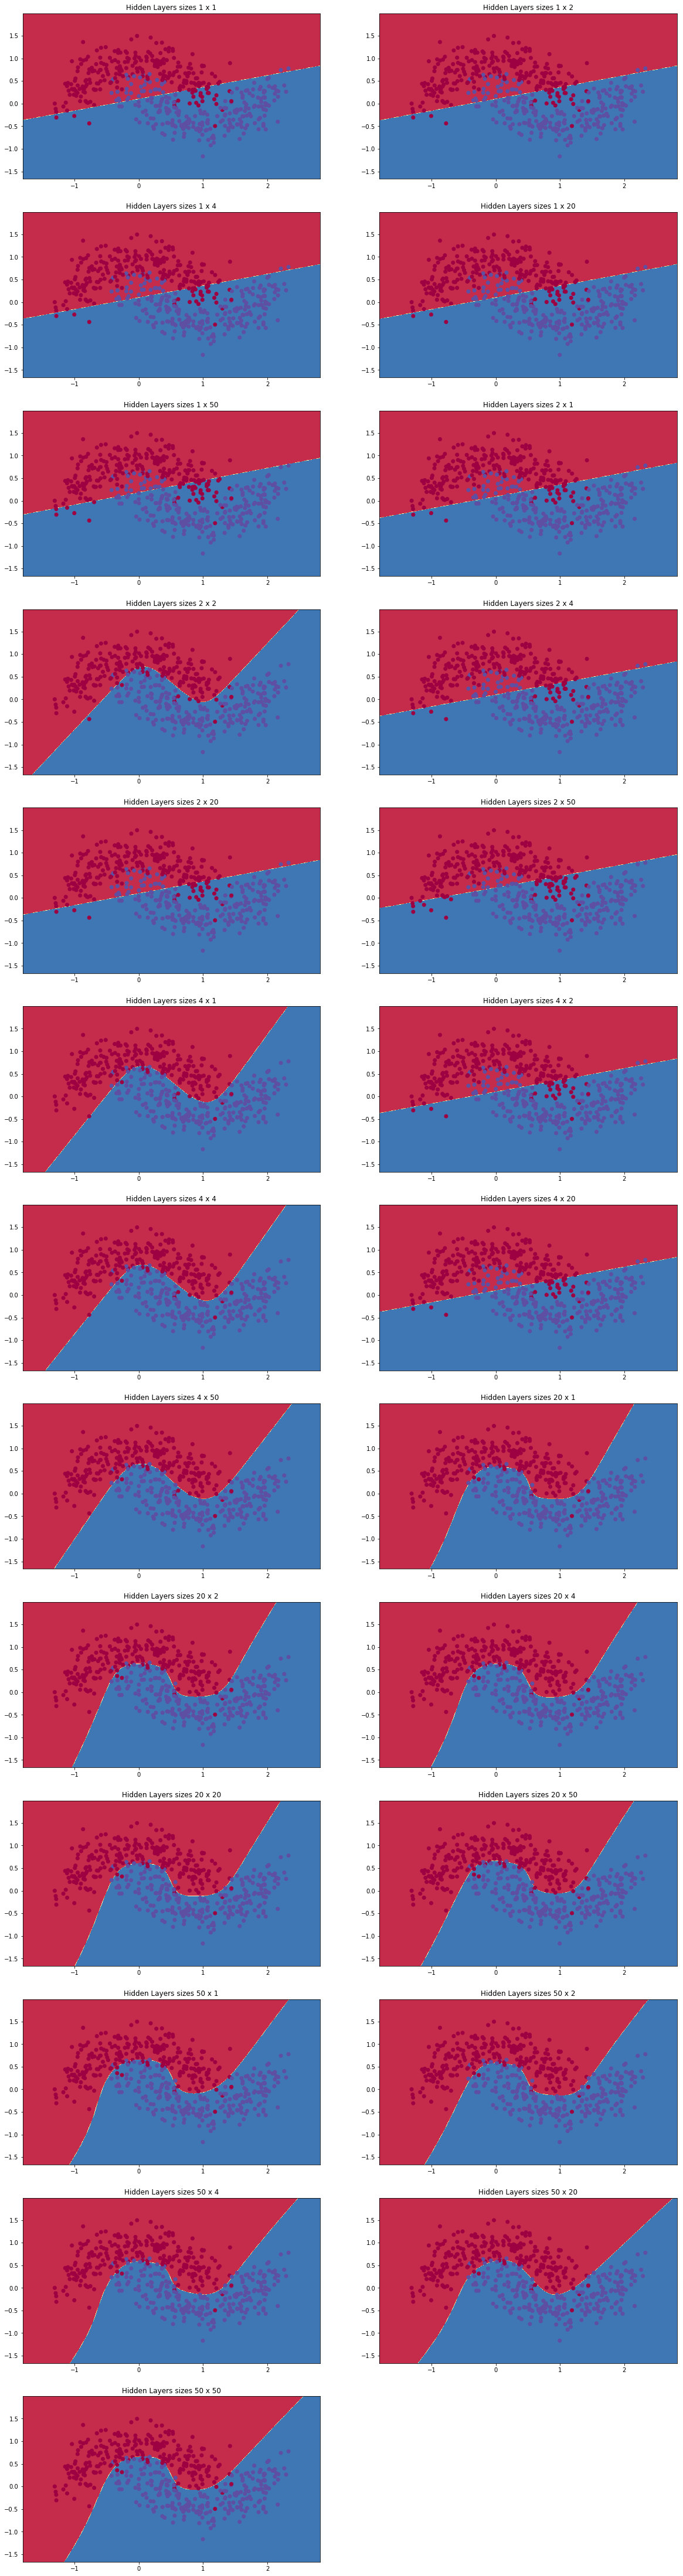

In [11]:
plt.figure(figsize=(20, 80))
import itertools

hidden_layer_dimensions = [1, 2, 4, 20, 50]
hidden_layer_dimensions = list(itertools.product(hidden_layer_dimensions, hidden_layer_dimensions))

for i, nn_hdim in enumerate(hidden_layer_dimensions):
    nn_hdim1 = nn_hdim[0]
    nn_hdim2 = nn_hdim[1]
    plt.subplot(13, 2, i+1)
    plt.title('Hidden Layers sizes %d x %d' % (nn_hdim1, nn_hdim2))
    model = train_nn(data, nn_hdim1,nn_hdim2)
    plot_decision_boundary(lambda x: predict(model, x))
plt.show()

# Analysis

When there is only 1 neuron in the first layer, the resulting decision boundary is always linear, regarless of the number of neurons in the second layer. This is likely because most of the information is lost in the first layer.

When there are relatively few (2 or 4) neurons in the first layer, depending on the size of the second layer, the model sometimes gives very nicely fitted boundary, but other times the boundary could still be linear. There doesn't seem to be any predictable patterns.

When the first layer has a relatively large number (20 or 50) of neurons, the model always yields a fitted decision boundary. The boundary is more curvy than when there are fewer neurons, but as the number of neurons increases, it becomes increasingly assymetrical. The reason might be that the model is reading too much into the data so just a few anomalies can greatly shift the boundary.